# WESAD Pipeline Verification & Exploration

This notebook demonstrates the **Hybrid Workflow**: using a notebook to visually audit the heavy-lifting code written in `src/`. This corresponds to the **Data Ingestion** and **Quality Control** phases of the pipeline.

**Objectives:**
1.  **Data Ingestion**: Load raw WESAD data using `WESADPreprocessor`.
2.  **Visualization**: Inspect raw physiological signals (EDA, Temp, ACC, ECG) to understand their characteristics.
3.  **Preprocessing**: Verify that downsampling (to 35Hz) and windowing logic works correctly.
4.  **Quality Control**: Test the **Signal Quality Index (SQI)** module to ensure it correctly flags flatlines (dead sensors) and high-motion artifacts.

In [1]:
# Load Configuration
%load_ext autoreload
%autoreload 2

# Import standard libraries
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import copy 

# Ensure we can import from src
import os
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import project modules
from src.config import load_config
from src.data.make_dataset import WESADPreprocessor
from src.features.sqi import SignalQualityIndex
# Import specific plotting functions to keep downstream cells clean
from src.visualization.plots import set_plot_style, plot_raw_signals, plot_resampling_verification_grid, plot_sqi_comparison

# Apply the unified project style
set_plot_style()
config = load_config()
print("Project Config Loaded:", config['data']['modalities'])

Project Config Loaded: ['EDA', 'ACC', 'TEMP', 'RESP', 'BVP']


## 1. Load Raw Data (Subject S2)
We use the helper method from our preprocessor to load the pickle file directly.

In [2]:
print(f"Current Pipeline Location: {config['data'].get('sensor_location', 'chest').upper()}")
# NB: CHEST or WRIST defined in configs/default.yaml

Current Pipeline Location: CHEST


In [3]:
# Load data for a specific subject
preprocessor = WESADPreprocessor() # NB: This requires the WESAD.zip to be unzipped in data/raw/WESAD

# Select subject ID
subject_id = 'S2'

# Load subject data
data = preprocessor.load_subject(subject_id)
print(f"Loaded {subject_id} keys:", data.keys())
print(f"Signal keys:", data['signal']['chest'].keys())

2026-01-17 00:13:23,794 - src.data.make_dataset - INFO - Loading C:\Users\matteucc\Desktop\Portfolio_improvement\Wearable_stress_biomarker\data\raw\WESAD\S2\S2.pkl
Loaded S2 keys: dict_keys(['signal', 'label', 'subject'])
Signal keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])


## 2. Visualize Raw Signals
Let's look at 60 seconds of raw data. The chest data is at 700Hz.

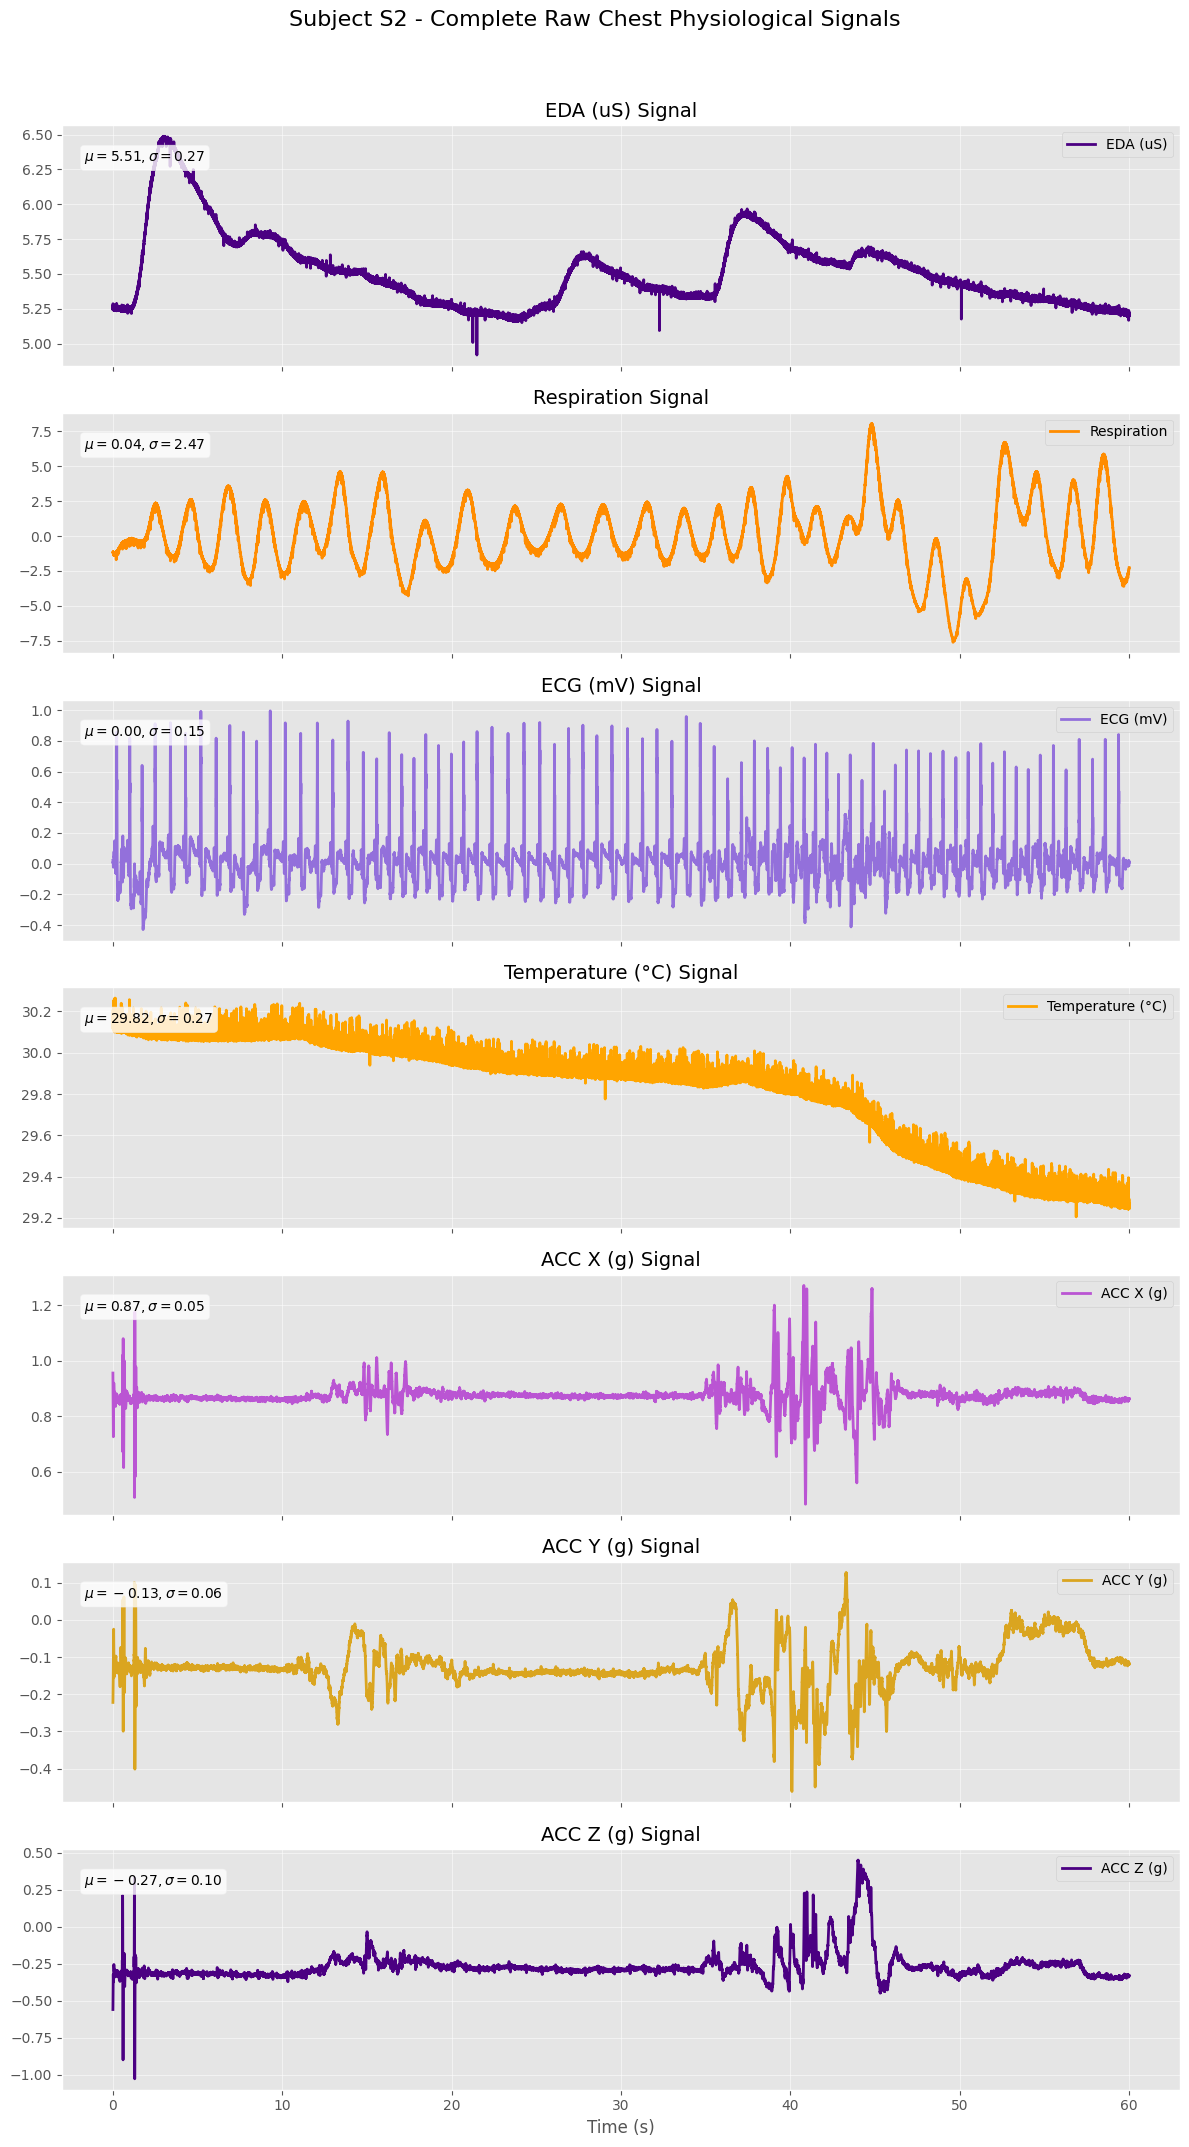

In [4]:
# Extract chest data for plotting
chest_data = data['signal']['chest']
fs = 700
duration_sec = 60
samples = fs * duration_sec

# Prepare complete chest data dictionary for inspection
# WESAD Chest Raw Keys: 'EDA', 'Resp', 'ECG', 'TC', 'ACC' (3-axis), 'Temp'
plotting_data = {
    'EDA (uS)': chest_data['EDA'][:samples].flatten(),
    'Respiration': chest_data['Resp'][:samples].flatten(),
    'ECG (mV)': chest_data['ECG'][:samples].flatten(),
    'Temperature (°C)': chest_data['Temp'][:samples].flatten(),
    'ACC X (g)': chest_data['ACC'][:samples, 0].flatten(),
    'ACC Y (g)': chest_data['ACC'][:samples, 1].flatten(),
    'ACC Z (g)': chest_data['ACC'][:samples, 2].flatten()
}
time_axis = np.arange(samples) / fs

# Plot all raw chest signals for the subject
loc = config['data'].get('sensor_location', 'chest').upper() # Get location for saving
fig = plot_raw_signals(time_axis, plotting_data, title=f"Subject {subject_id} - Complete Raw Chest Physiological Signals", save_folder=loc)
plt.show()

## 3. Verify Resampling & Windowing
Our pipeline downsamples to 35Hz to make the data manageable for ML.
Let's run the `process_subject` method and inspect the first generated window.

In [5]:
# This calls the actual logic from src/data/make_dataset.py
windows = preprocessor.process_subject(subject_id)
print(f"Generated {len(windows)} windows for {subject_id}")

# Look at the first window
sample_window = windows[0]
print("Window Keys:", sample_window.keys())
print("Shape of EDA in window:", np.array(sample_window['EDA']).shape)
print("Label:", sample_window['label'])

2026-01-17 00:13:27,946 - src.data.make_dataset - INFO - Loading C:\Users\matteucc\Desktop\Portfolio_improvement\Wearable_stress_biomarker\data\raw\WESAD\S2\S2.pkl
2026-01-17 00:13:37,038 - src.data.make_dataset - INFO - Subject S2: 71 windows created.
Generated 71 windows for S2
Window Keys: dict_keys(['subject_id', 'label', 'start_idx', 'ACC_x', 'ACC_y', 'ACC_z', 'ECG', 'EDA', 'RESP', 'TEMP'])
Shape of EDA in window: (2100,)
Label: 1


Aligning Trace: First valid window starts at t=300.00s


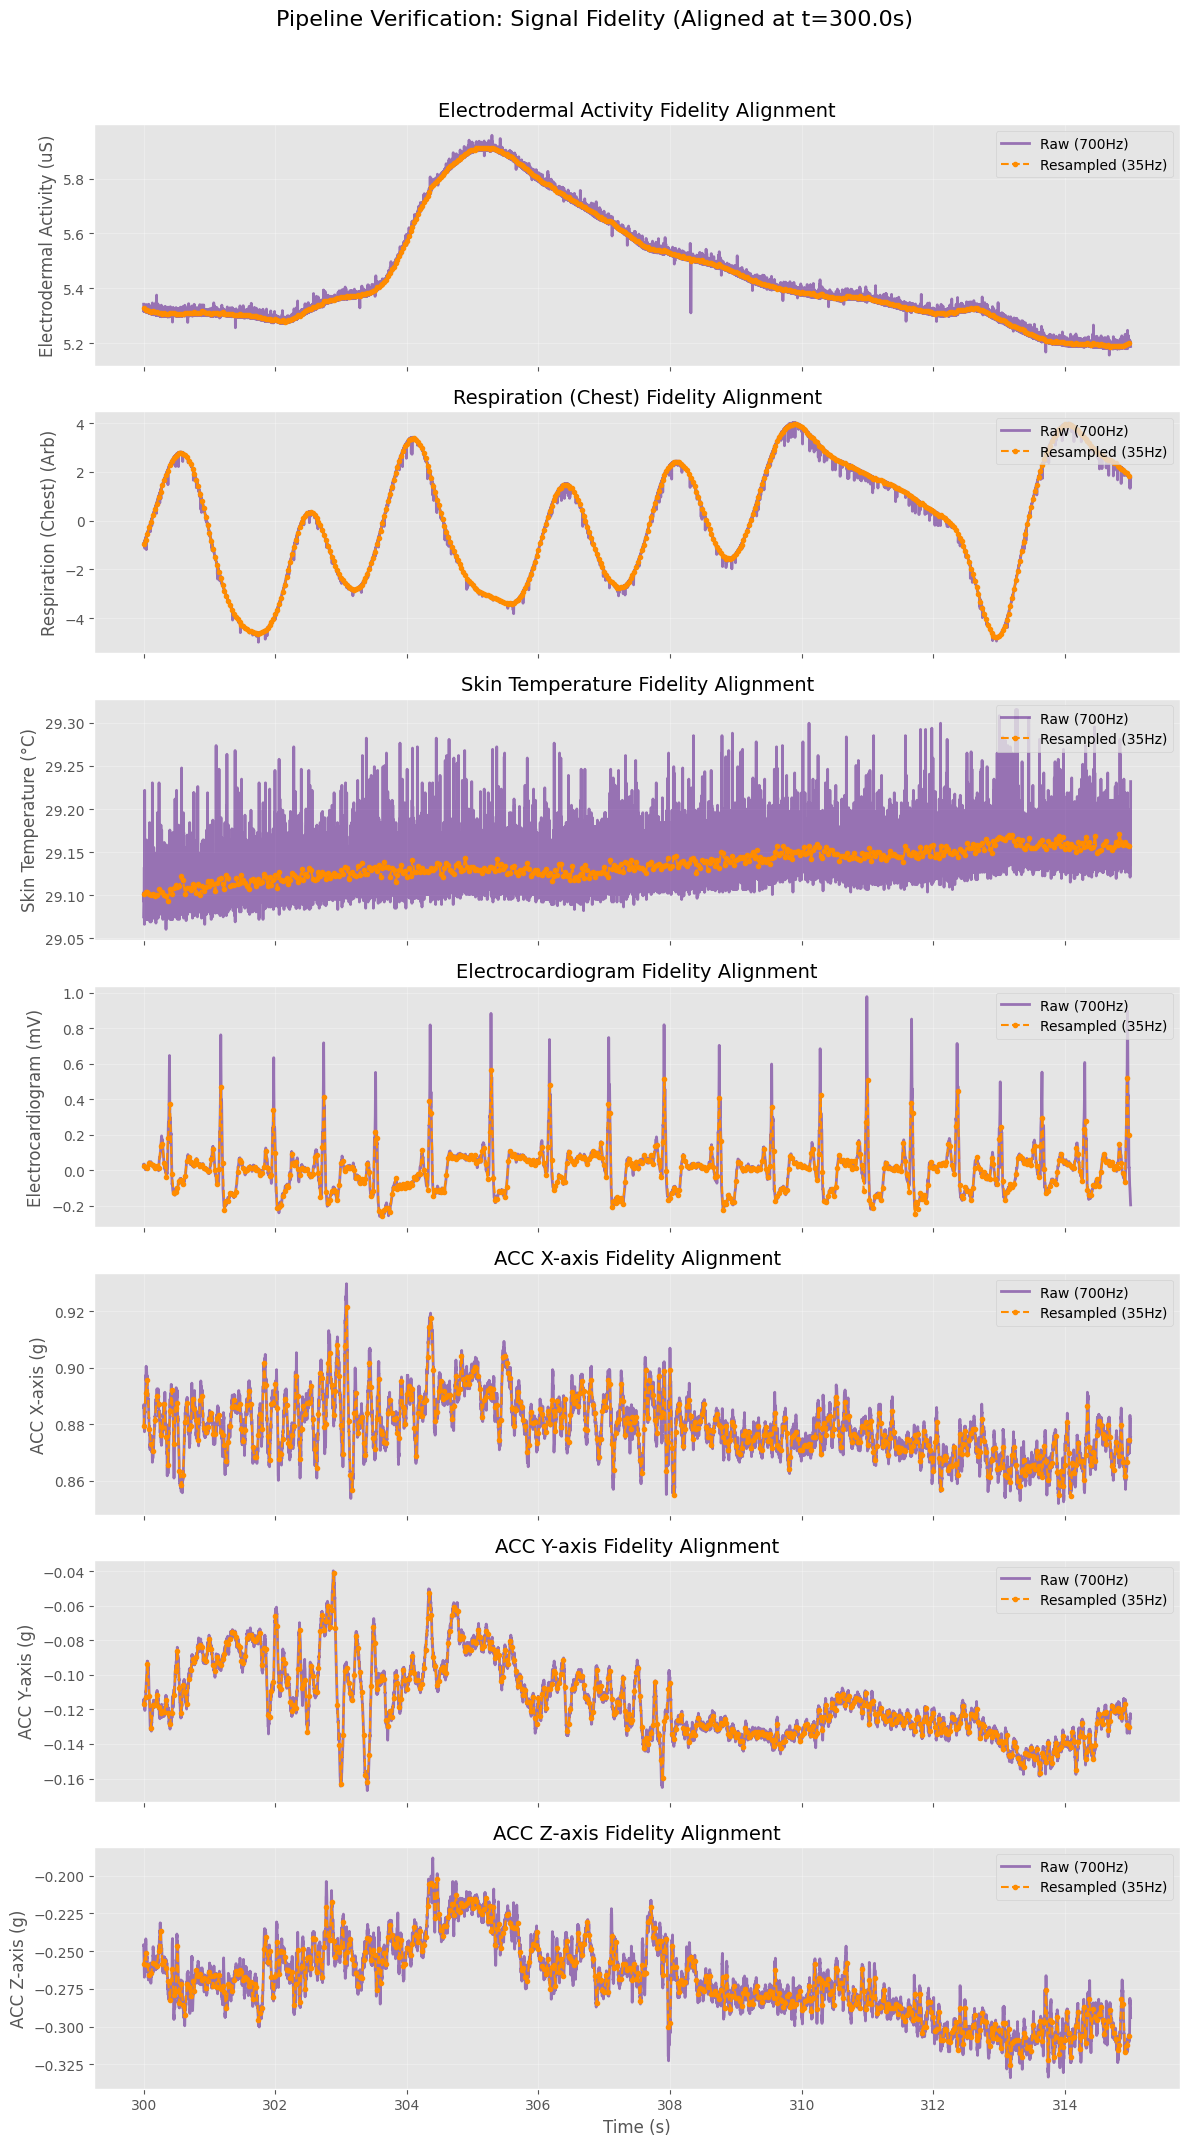

In [6]:
# Shared Parameters
raw_fs = 700
target_fs = preprocessor.target_fs
plot_duration = 15 # Shorter window to see details clearly in grid

# Alignment Logic: Get start time of the first processed window
sample_window = windows[0]
start_time = sample_window['start_idx'] / target_fs

print(f"Aligning Trace: First valid window starts at t={start_time:.2f}s")
loc = config['data'].get('sensor_location', 'chest').upper() # Get location for saving

# Use our new dedicated verification grid plotter
# This handles looping over all modalities (EDA, Resp, Temp, ECG, ACC) automatically
fig = plot_resampling_verification_grid(
    chest_data, 
    sample_window, 
    start_time, 
    raw_fs=raw_fs, 
    target_fs=target_fs, 
    plot_duration=plot_duration,
    save_folder=loc
)
plt.show()

## 4. Signal Quality Index (SQI) Check
The **Signal Quality Index (SQI)** module is a critical "Gatekeeper" layer. It prevents garbage data from reaching the ML model by flagging windows with sensor disconnects or excessive motion noise.

**Metrics & Logic:**
The `overall_sqi` score (0.0 to 1.0) is a composite of multiple checks defined in `src/features/sqi.py` and configured via `configs/default.yaml`.

*   **Dead Sensor Check (Connectivity)**:
    *   Detects "Flatlines" where the signal variance is suspiciously low (e.g., sensor fell off).
    *   **EDA**: Flatline if range < 0.005 $\mu S$.
    *   **Temp**: Flatline if range < 0.01 $^\circ C$.
    *   **ECG**: Flatline if range < 0.05 mV.
*   **Noise Check (Reliability)**:
    *   **Motion**: Detects high-intensity activity using the 3-axis Accelerometer.
    *   **Threshold**: Windows with ACC Standard Deviation > 0.5g are flagged as noisy.

**Interpretation:**
Windows with `overall_sqi < 0.7` are rejected during the training pipeline.
*   **Left Plots**: Physiological Signal (Red line indicates flatline threshold).
*   **Right Plots**: Motion intensity (Red line indicates noise threshold).

--- Running Scenarios for Signal: ECG ---
Loaded Flatline Threshold for ECG: 0.05 (from config)


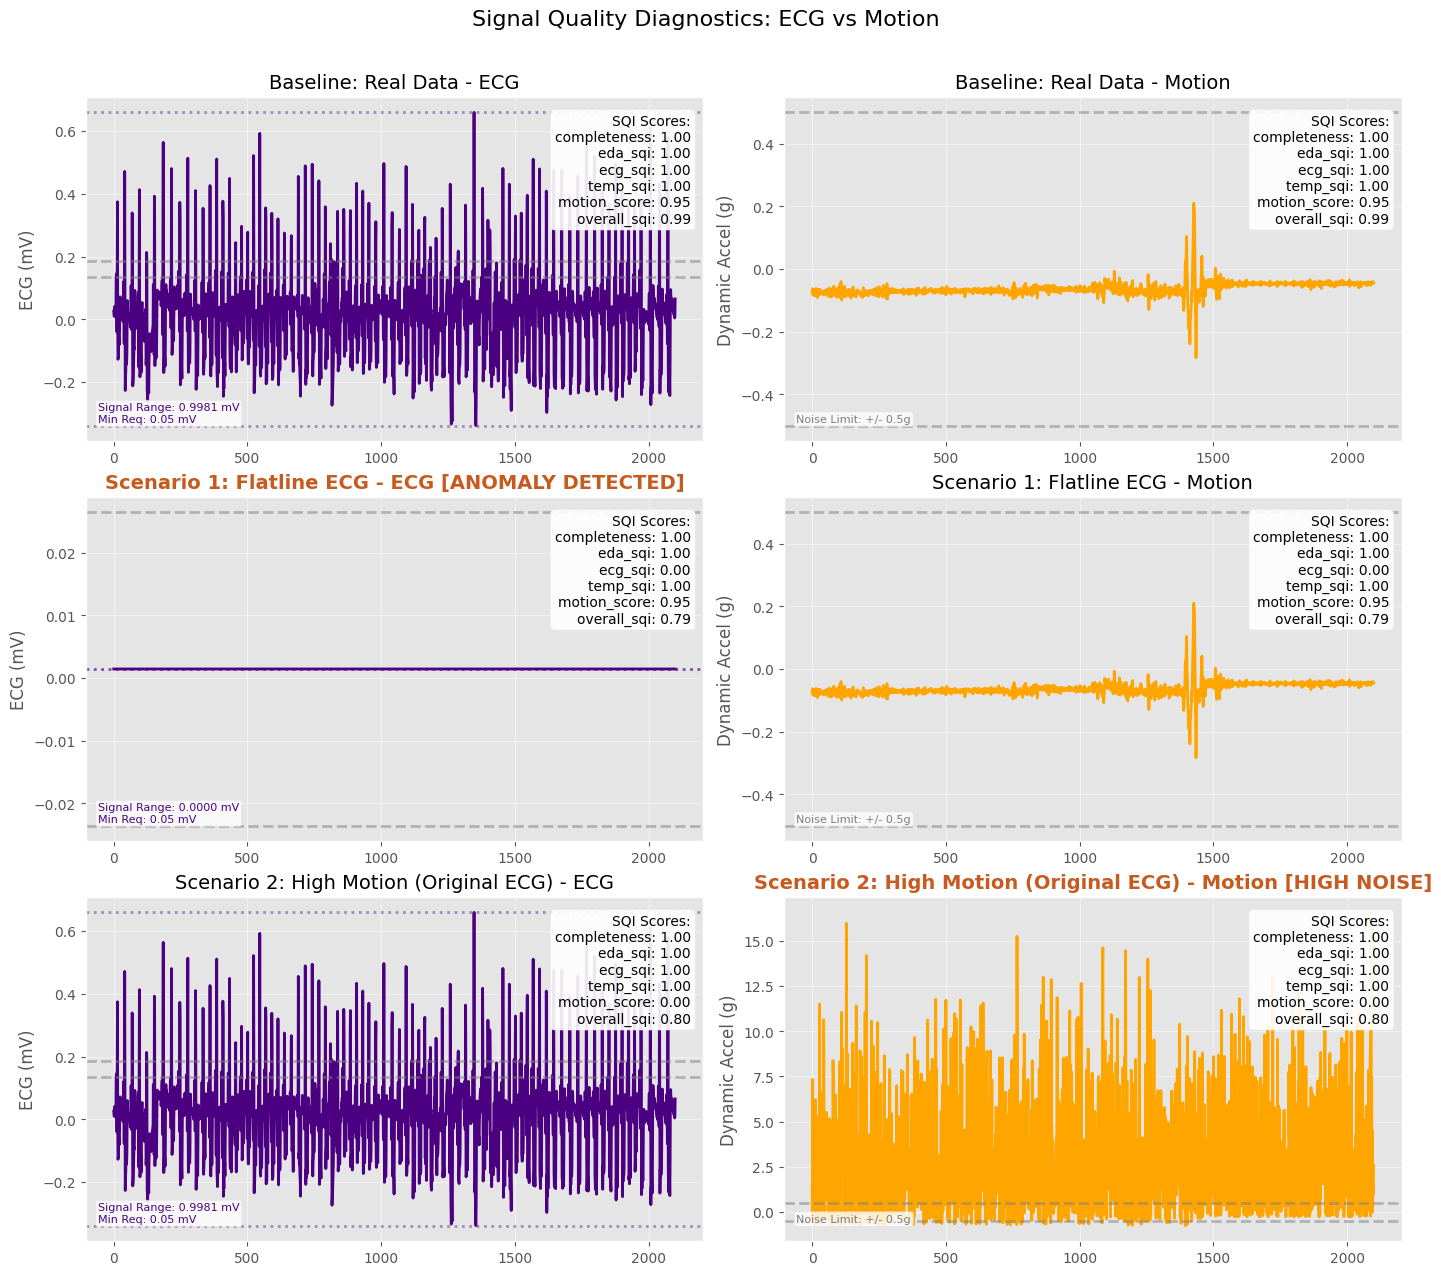

In [7]:
# Initialize SQI Calculator
sqi = SignalQualityIndex(config) 

# Select Which Signal to Inspect
selected_signal = 'ECG' 
print(f"--- Running Scenarios for Signal: {selected_signal} ---")
print(f"Loaded Flatline Threshold for {selected_signal}: {sqi.flatline_thresholds.get(selected_signal)} (from config)")

# Prepare Scenarios
scenarios = []

# 1. Real Window: Baseline (original data)
real_window = windows[0]
real_score = sqi.compute_sqi(real_window)
scenarios.append((real_window, "Baseline: Real Data", real_score))

# 2. "Scenario 1": Fake 'Flatline' Window (Bad Signal, Good Motion)
flat_signal_window = copy.deepcopy(windows[0])
signal_mean = np.mean(flat_signal_window[selected_signal])
flat_signal_window[selected_signal] = np.ones_like(flat_signal_window[selected_signal]) * signal_mean
flat_signal_score = sqi.compute_sqi(flat_signal_window)
scenarios.append((flat_signal_window, f"Scenario 1: Flatline {selected_signal}", flat_signal_score))

# 3. "Scenario 2": Fake 'Motion Artifact' Window (Good Signal, Bad Motion)
noisy_motion_window = copy.deepcopy(windows[0])
noisy_motion_window['ACC_x'] = np.random.normal(0, 5, len(noisy_motion_window['ACC_x'])) 
noisy_motion_score = sqi.compute_sqi(noisy_motion_window)
scenarios.append((noisy_motion_window, f"Scenario 2: High Motion (Original {selected_signal})", noisy_motion_score))

# Plot Comparison (Passing thresholds explicitly for visualization accuracy)
fig = plot_sqi_comparison(scenarios, signal_key=selected_signal, thresholds=sqi.flatline_thresholds)
plt.show()

## 5. Real-World Audit
Finally, let's run the full **Signal Quality Index (SQI)** algorithm on **every single window** generated for this subject and inspect some of them visually.

Auditing all 71 windows for Subject S2...
Visualizing audit logic for: ECG
Acceptance Criteria: Overall SQI >= 0.7
--- Quality Statistics ---
Total Windows: 71
Accepted (SQI >= 0.7): 71 (100.0%)
Rejected (SQI < 0.7):  0 (0.0%)

--- Extremes & Median Analysis ---
Best Window   (Idx 60): Score = 0.9993
Median Window (Idx 17): Score = 0.9981
Worst Window  (Idx 37): Score = 0.9734

NOTE: Even the 'Worst' window has a high score. This subject has very clean data.
The visual difference might be subtle (e.g., slight posture change vs sitting still).


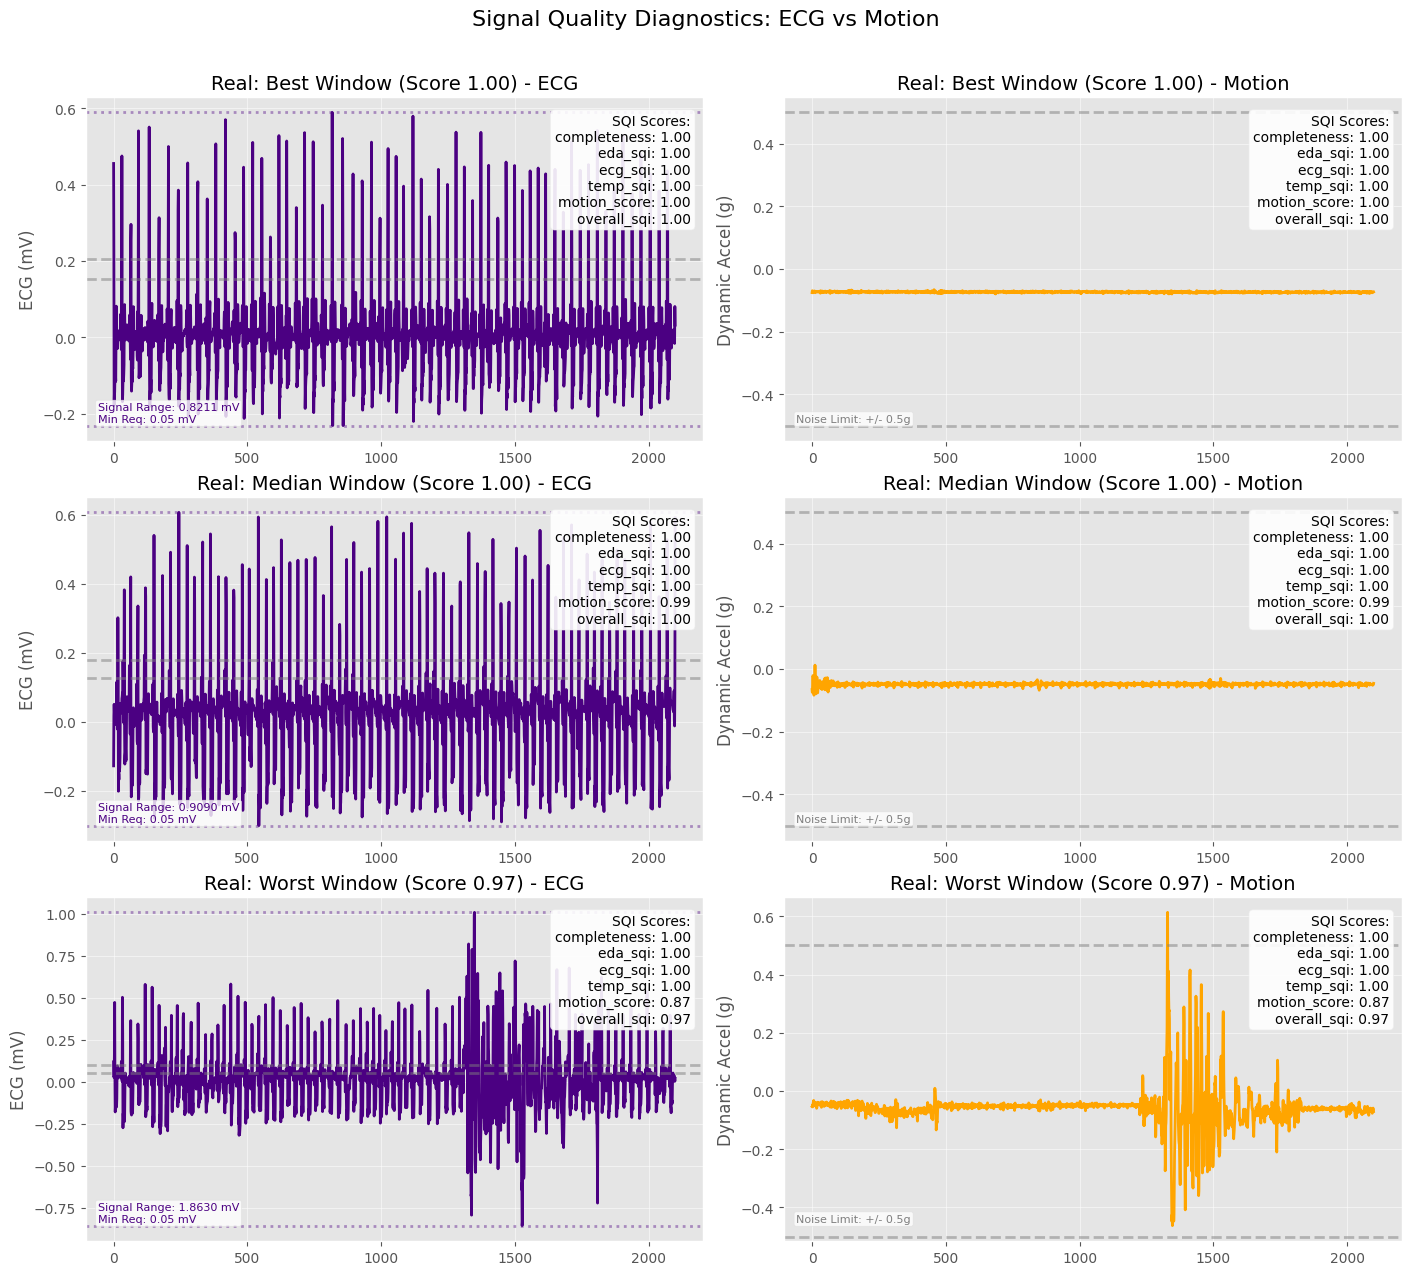

In [8]:
# 5. Real-World Audit: Processing All Subject Windows
print(f"Auditing all {len(windows)} windows for Subject {subject_id}...")

# Use the same signal we selected above for consistency, or override here
audit_signal = selected_signal 
print(f"Visualizing audit logic for: {audit_signal}")
print(f"Acceptance Criteria: Overall SQI >= {sqi.acceptance_threshold}")

results = []
for i, win in enumerate(windows):
    # The 'is_acceptable' method now uses the configured threshold (0.7)
    is_good = sqi.is_acceptable(win) 
    scores = sqi.compute_sqi(win)
    results.append({'index': i, 'is_good': is_good, 'scores': scores})

# Statistics
good_count = sum(1 for r in results if r['is_good'])
bad_count = len(results) - good_count

print(f"--- Quality Statistics ---")
print(f"Total Windows: {len(windows)}")
print(f"Accepted (SQI >= {sqi.acceptance_threshold}): {good_count} ({good_count/len(windows)*100:.1f}%)")
print(f"Rejected (SQI < {sqi.acceptance_threshold}):  {bad_count} ({bad_count/len(windows)*100:.1f}%)")

# Find Examples for Plotting
scores_list = [r['scores']['overall_sqi'] for r in results]
best_idx = np.argmax(scores_list)
worst_idx = np.argmin(scores_list)

# Find Median
sorted_indices = np.argsort(scores_list)
median_idx = sorted_indices[len(scores_list)//2]

print(f"\n--- Extremes & Median Analysis ---")
print(f"Best Window   (Idx {best_idx}): Score = {scores_list[best_idx]:.4f}")
print(f"Median Window (Idx {median_idx}): Score = {scores_list[median_idx]:.4f}")
print(f"Worst Window  (Idx {worst_idx}): Score = {scores_list[worst_idx]:.4f}")

if scores_list[worst_idx] > 0.8:
    print("\nNOTE: Even the 'Worst' window has a high score. This subject has very clean data.")
    print("The visual difference might be subtle (e.g., slight posture change vs sitting still).")

real_scenarios = [
    (windows[best_idx], f"Real: Best Window (Score {scores_list[best_idx]:.2f})", results[best_idx]['scores']),
    (windows[median_idx], f"Real: Median Window (Score {scores_list[median_idx]:.2f})", results[median_idx]['scores']),
    (windows[worst_idx], f"Real: Worst Window (Score {scores_list[worst_idx]:.2f})", results[worst_idx]['scores'])
]

loc = config['data'].get('sensor_location', 'chest').upper() # Get location for saving
fig = plot_sqi_comparison(real_scenarios, signal_key=audit_signal, thresholds=sqi.flatline_thresholds, save_folder=loc)
plt.show()